In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ast
from collections import defaultdict


class GOTerm(object):
    '''
    A class representing a GO term
    '''
    def __init__(self, name):
        self.name = name
        self.experiments = {}

In [25]:
# Load in the hyperparameter results

go_terms = []

with open('./Experiments/Raw/Mixed_weights/LSTM/svm_mixed_hyperparameter_results_3.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
    	result_array = line.split(', ')

    	name = result_array[0]
    	hyperparameters = ast.literal_eval(', '.join(result_array[1:-1]))
    	f1 = float(result_array[-1][:-1])

    	go_term = GOTerm(name)
    	go_term.experiments['representation'] = {'hyperparameters': hyperparameters, 'f1': f1}

    	go_terms.append(go_term)


with open('./Experiments/Raw/Mixed_weights/Features/svm_feature_mixed_hyperparameter_results_3.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
    	result_array = line.split(', ')

    	name = result_array[0]
    	hyperparameters = ast.literal_eval(', '.join(result_array[1:-1]))
    	f1 = float(result_array[-1][:-1])

    	go_term = filter(lambda x: x.name == name, go_terms)

    	try:
    		go_term = list(go_term)[0]
    		go_term.experiments['features'] = {'hyperparameters': hyperparameters, 'f1': f1}

    	except(IndexError):
    		continue

with open('./standard_lstm_hyperparameter_results_2.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        result_array = line.split(', ')

        name = result_array[0]
        hyperparameters = ast.literal_eval(', '.join(result_array[1:-1]))
        f1 = float(result_array[-1][:-1])

        go_term = filter(lambda x: x.name == name, go_terms)        

        try:
            go_term = list(go_term)[0]
            go_term.experiments['standard'] = {'hyperparameters': hyperparameters, 'f1': f1}

        except(IndexError):
            continue

In [26]:
go_terms = list(filter(lambda x: len(list(x.experiments.keys())) == 3, go_terms))

In [28]:
feature_f1s = list(map(lambda x: x.experiments['features']['f1'], go_terms))
representation_f1s = list(map(lambda x: x.experiments['representation']['f1'], go_terms))
standard_f1s = list(map(lambda x: x.experiments['standard']['f1'], go_terms))

print('Performance of each model:\n')
print("Mean F1 Score for psipred features: %f" % np.mean(feature_f1s))
print("Mean F1 Score for psipred representation: %f" % np.mean(representation_f1s))
print("Mean F1 Score for psipred standard: %f" % np.mean(standard_f1s))


Performance of each model:

Mean F1 Score for psipred features: 0.340545
Mean F1 Score for psipred representation: 0.282581
Mean F1 Score for psipred standard: 0.229229


<IPython.core.display.Javascript object>


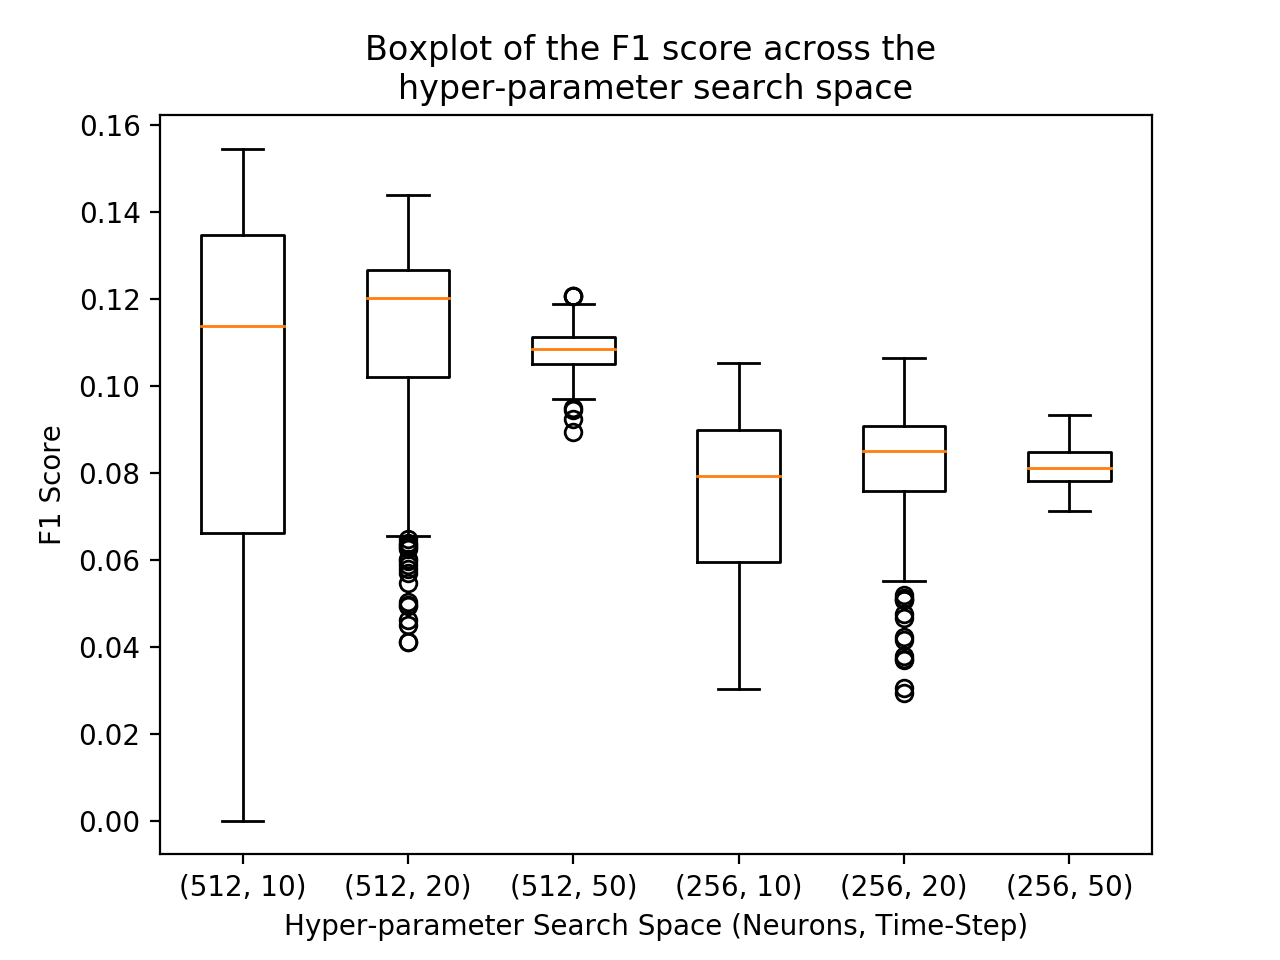

<IPython.core.display.Javascript object>


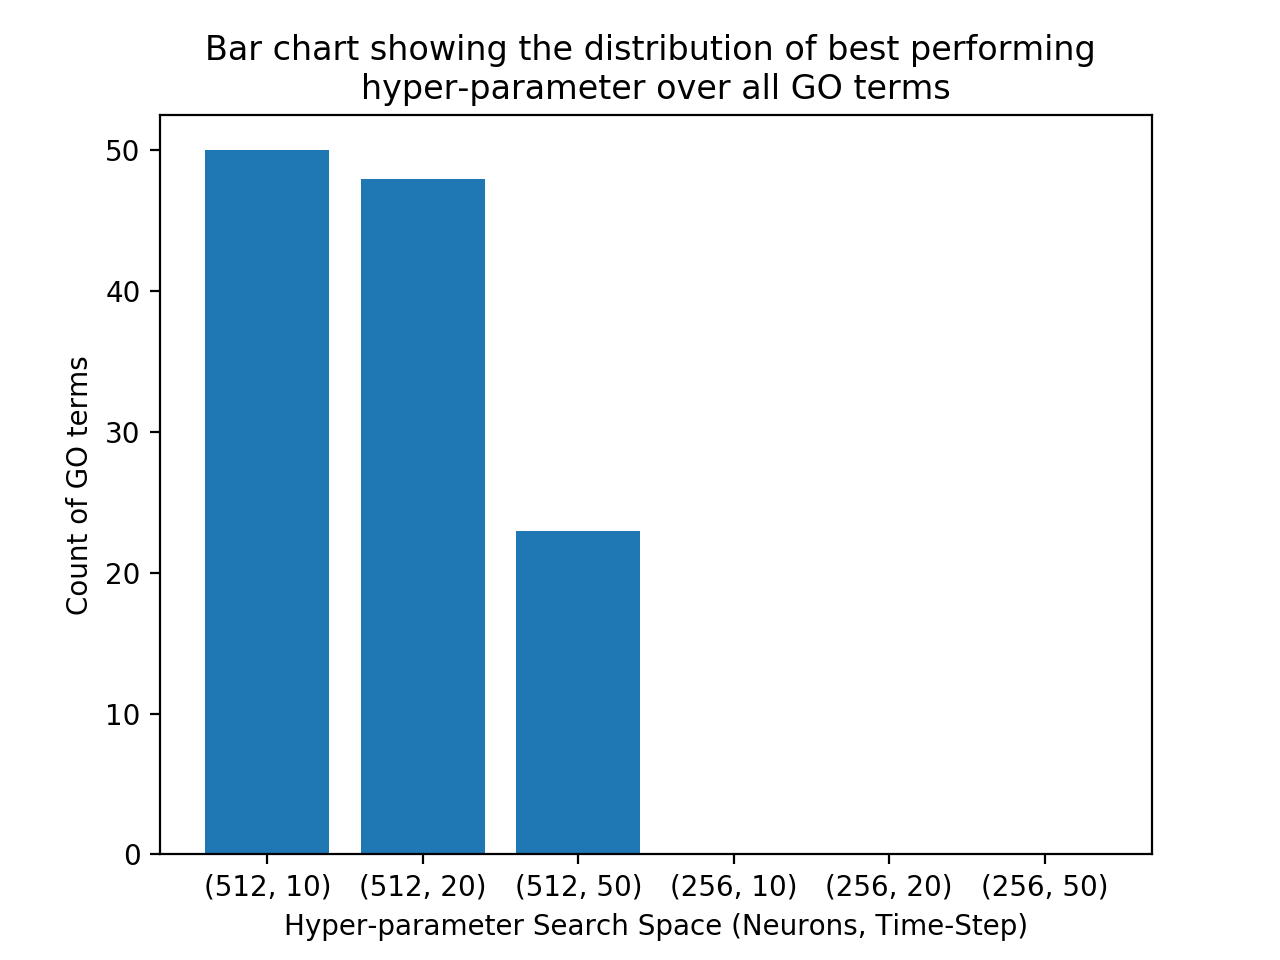

In [29]:
import dill as pickle

hyper_parameter_results = defaultdict(list)
with open('hyperparameter_results.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        result = line.split(', ')
        
        go_term = str(result[0])
        neurons = int(result[1])
        time_step = int(result[2])
        f1_score = float(result[3])
        
        hyper_parameter_results[(neurons, time_step)].append(f1_score)

with open('best_hyper_dict.pkl', 'rb') as f:
    best_hyper_dict = pickle.load(f)
        
hyperparameter_set_counts = defaultdict(int)

for go_term in go_terms:
    best_hyperparameters = best_hyper_dict[go_term.name]
    hyperparameter_set_counts[best_hyperparameters] += 1

xtick_labels = ["(512, 10)", "(512, 20)", "(512, 50)", "(256, 10)", "(256, 20)", "(256, 50)"]    
boxplot_data = [hyper_parameter_results[key] for key in hyper_parameter_results.keys()]

fig, ax = plt.subplots(1, 1)

ax.boxplot(boxplot_data)
ax.set_xlabel('Hyper-parameter Search Space (Neurons, Time-Step)')
ax.set_ylabel('F1 Score')
ax.set_title('Boxplot of the F1 score across the \nhyper-parameter search space')
ax.set_xticklabels(xtick_labels)

plt.show()

fig, ax = plt.subplots(1, 1)
            
ax.bar(np.arange(0, 6), [50, 48, 23, 0, 0, 0])
ax.set_title('Bar chart showing the distribution of best performing \nhyper-parameter over all GO terms')
ax.set_xlabel('Hyper-parameter Search Space (Neurons, Time-Step)')
ax.set_ylabel('Count of GO terms')
xtick_labels = ["0", "(512, 10)", "(512, 20)", "(512, 50)", "(256, 10)", "(256, 20)", "(256, 50)"]
ax.set_xticklabels(xtick_labels)
plt.show()



In [32]:
def kernel_hypers_bars(path):
    kernel_count = defaultdict(int)
    rbf_hyper_count = defaultdict(int)

    C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
    gamma = [0.0001, 0.001, 0.01, 0.03, 0.1, 0.2, 0.5, 3, 10]

    with open(path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            results = line.split('{')
            go_term = str(results[0])[:-2]
            if go_term in [gt.name for gt in go_terms]:
                f1 = float(go_term[2])
                param_dict = ast.literal_eval("{" + results[1].split('}')[0] + '}')

                kernel_count[(param_dict['kernel'], param_dict['class_weight'])] += 1

                if param_dict['kernel'] == 'rbf' and param_dict['class_weight'] == 'balanced':
                    rbf_hyper_count[(param_dict['C'], param_dict['gamma'])] += 1
                    


    keys = kernel_count.keys()
    values = np.array(list(kernel_count.values()))

    sorted_index = np.argsort(values)[::-1]
    
    xtick_labels = [0]
    for index in sorted_index:
        xtick_labels.append(list(keys)[index])
    
    return np.arange(0, len(values)), values[sorted_index], xtick_labels

def kernel_hypers_heatmap(path):
    kernel_count = defaultdict(int)
    rbf_hyper_count = defaultdict(int)

    C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
    gamma = [0.0001, 0.001, 0.01, 0.03, 0.1, 0.2, 0.5, 3, 10]

    with open(path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            results = line.split('{')
            go_term = str(results[0])[:-2]
            if go_term in [gt.name for gt in go_terms]:
                f1 = float(go_term[2])
                param_dict = ast.literal_eval("{" + results[1].split('}')[0] + '}')

                kernel_count[(param_dict['kernel'], param_dict['class_weight'])] += 1

                if param_dict['kernel'] == 'rbf' and param_dict['class_weight'] == 'balanced':
                    rbf_hyper_count[(param_dict['C'], param_dict['gamma'])] += 1


    hyper_map = np.zeros((len(C), len(gamma)))

    for c_index, c in enumerate(C):
        for g_index, g in enumerate(gamma):
            hyper_map[c_index, g_index] = rbf_hyper_count[(c, g)]

    
    c = [0]
    g = [0]

    for cc in C:
        c.append(cc)
    for gg in gamma:
        g.append(gg)

    return hyper_map, c, g

<IPython.core.display.Javascript object>


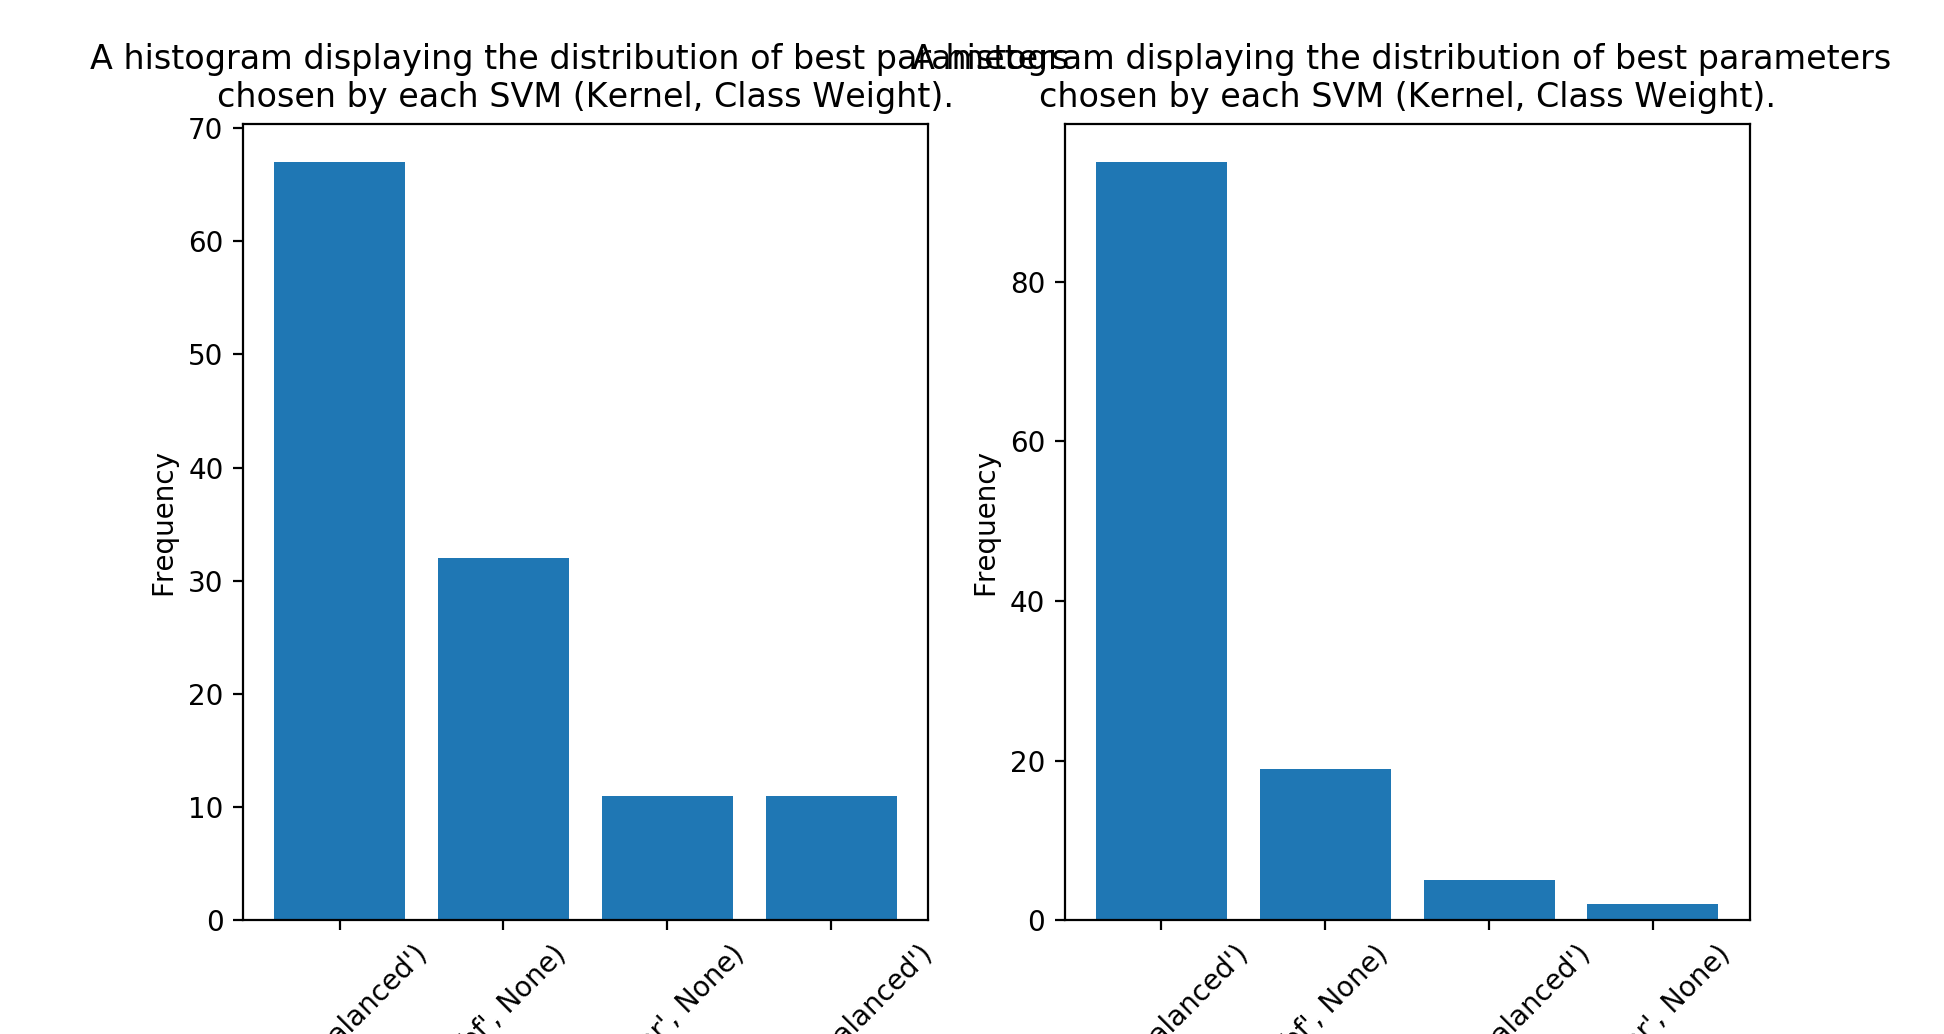

<IPython.core.display.Javascript object>


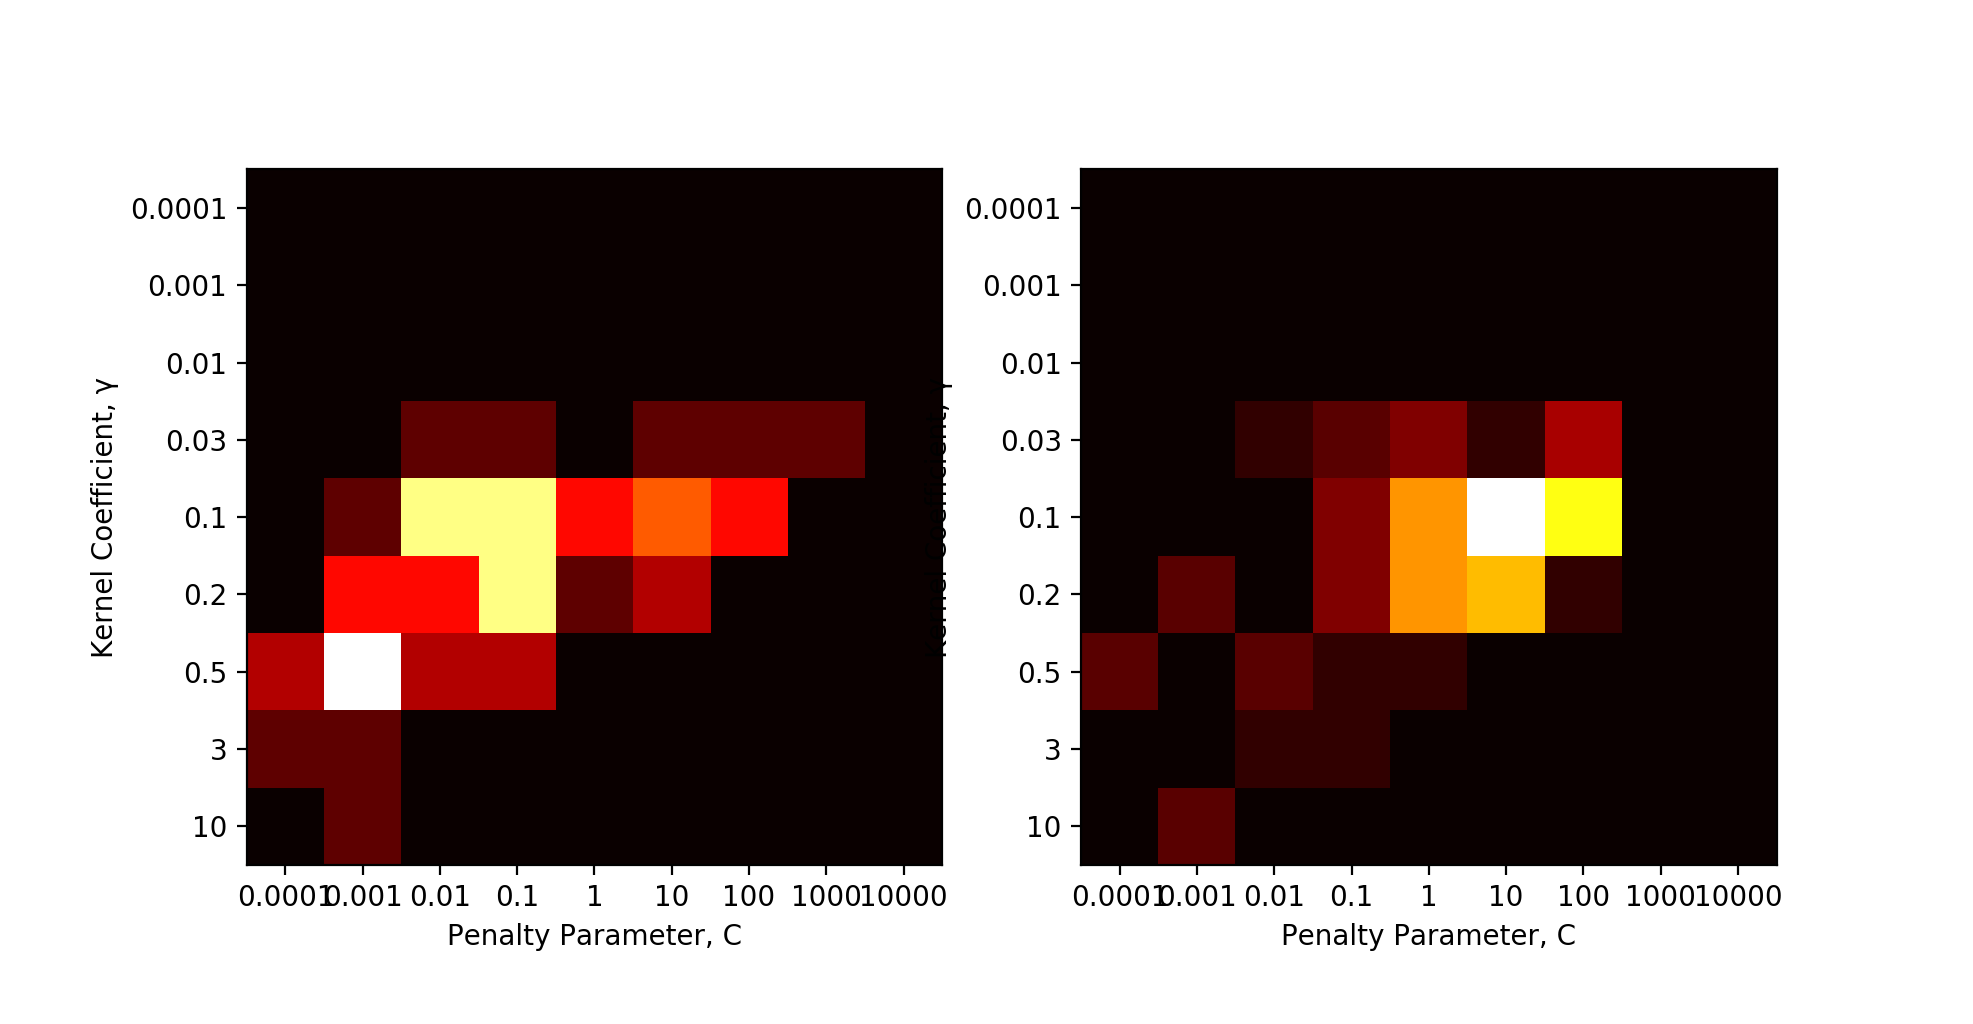

In [40]:
%matplotlib notebook
X1, y1, labels1 = kernel_hypers_bars('./Experiments/Raw/Mixed_weights/LSTM/svm_mixed_hyperparameter_results_3.txt')
X2, y2, labels2 = kernel_hypers_bars('./Experiments/Raw/Mixed_weights/Features/svm_feature_mixed_hyperparameter_results_3.txt')

fig, ax = plt.subplots(1, 2)
ax[0].bar(X1, y1)
ax[1].bar(X2, y2)

ax[0].set_xticklabels(labels1)
ax[1].set_xticklabels(labels2)
ax[0].tick_params(axis='x', rotation=45)
ax[1].tick_params(axis='x', rotation=45)

ax[0].locator_params(axis='x', nbins=6)
ax[1].locator_params(axis='x', nbins=6)
ax[0].set_xlabel('Hyper-parameter Search Space (Kernel, Class Weight)')
ax[0].set_ylabel('Frequency')
ax[1].set_xlabel('Hyper-parameter Search Space (Kernel, Class Weight)')
ax[1].set_ylabel('Frequency')
ax[0].set_title('A histogram displaying the distribution of best parameters \nchosen by each SVM (Kernel, Class Weight).')
ax[1].set_title('A histogram displaying the distribution of best parameters \nchosen by each SVM (Kernel, Class Weight).')
plt.show()

hm1, c1, g1 = kernel_hypers_heatmap('./Experiments/Raw/Mixed_weights/LSTM/svm_mixed_hyperparameter_results_3.txt')
hm2, c2, g2 = kernel_hypers_heatmap('./Experiments/Raw/Mixed_weights/Features/svm_feature_mixed_hyperparameter_results_3.txt')

fig, ax = plt.subplots(1, 2)
clr1 = ax[0].imshow(hm1, cmap='hot', interpolation='nearest')
clr2 = ax[1].imshow(hm2, cmap='hot', interpolation='nearest')

ax[0].set_xticklabels(c1)
ax[0].set_yticklabels(g1)
ax[0].locator_params(axis='x', nbins=16)

ax[1].set_xticklabels(c2)
ax[1].set_yticklabels(g2)
ax[1].locator_params(axis='x', nbins=16)

ax[0].set_xlabel('Penalty Parameter, C')
ax[0].set_ylabel('Kernel Coefficient, γ')

ax[1].set_xlabel('Penalty Parameter, C')
ax[1].set_ylabel('Kernel Coefficient, γ')
plt.show()

<IPython.core.display.Javascript object>


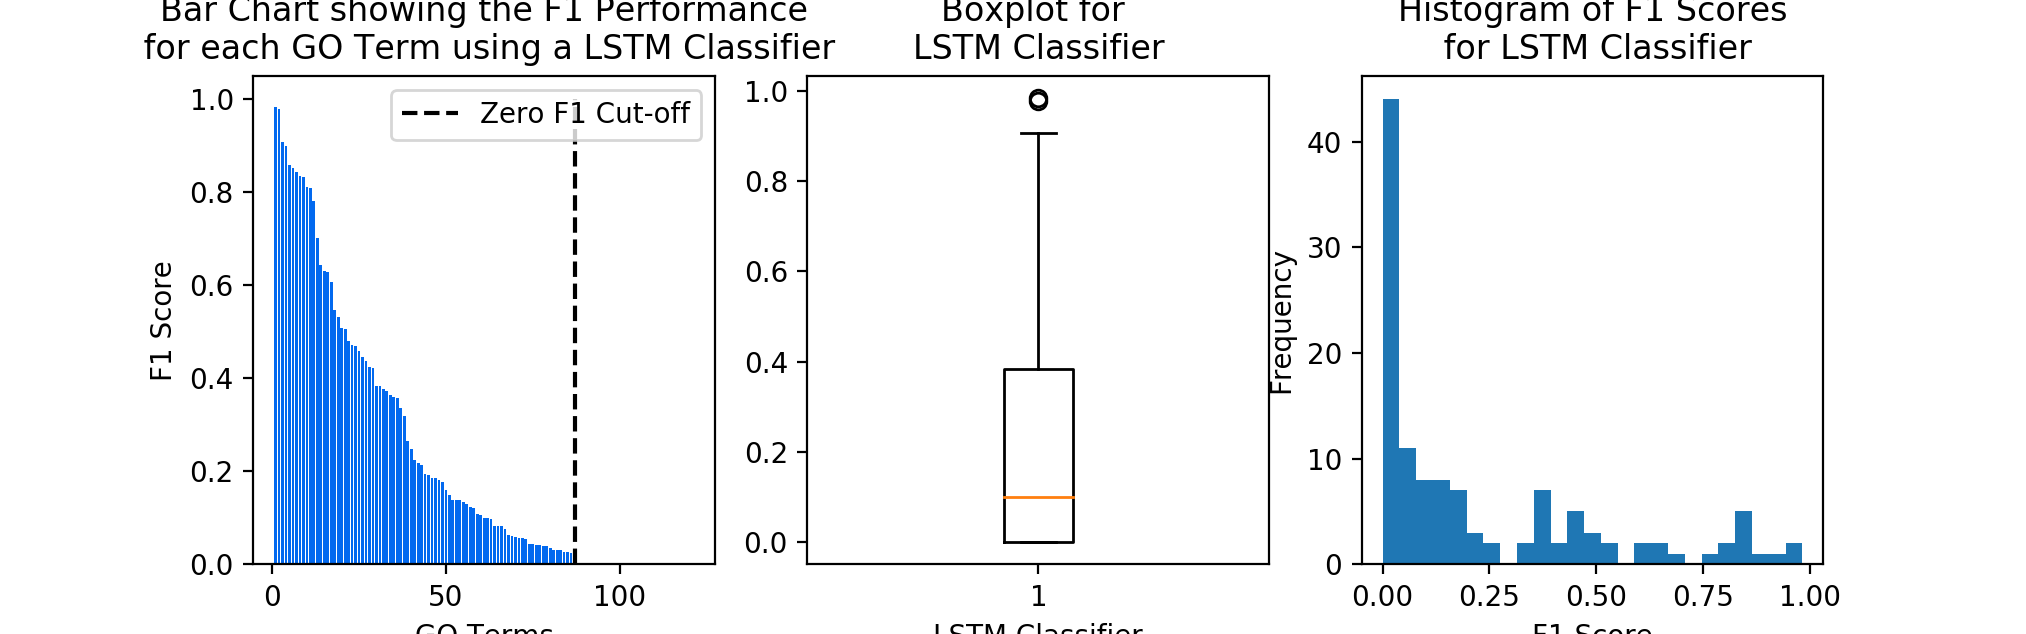

<IPython.core.display.Javascript object>


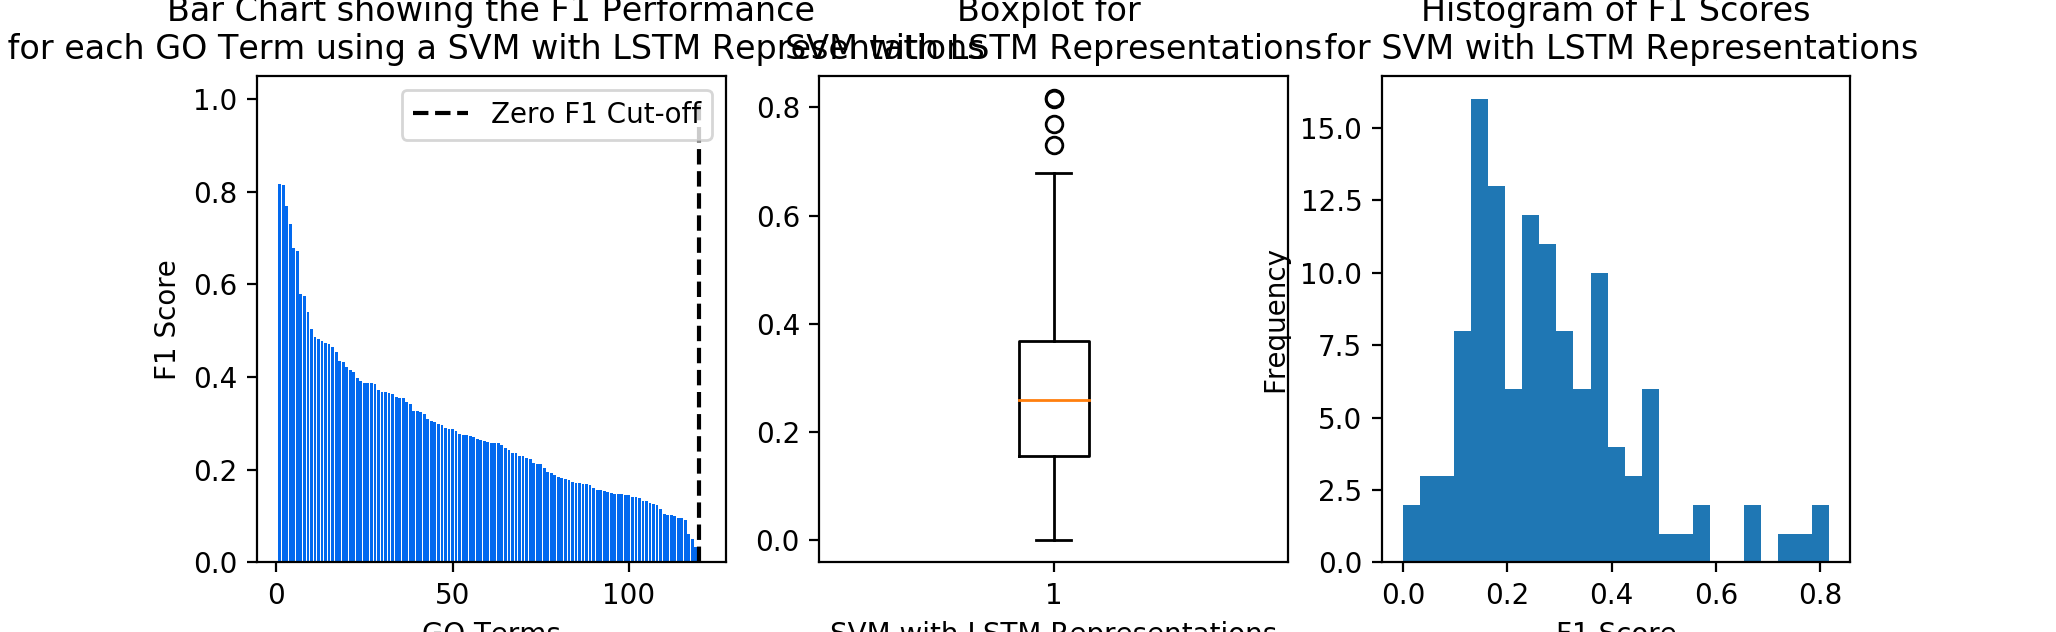

<IPython.core.display.Javascript object>


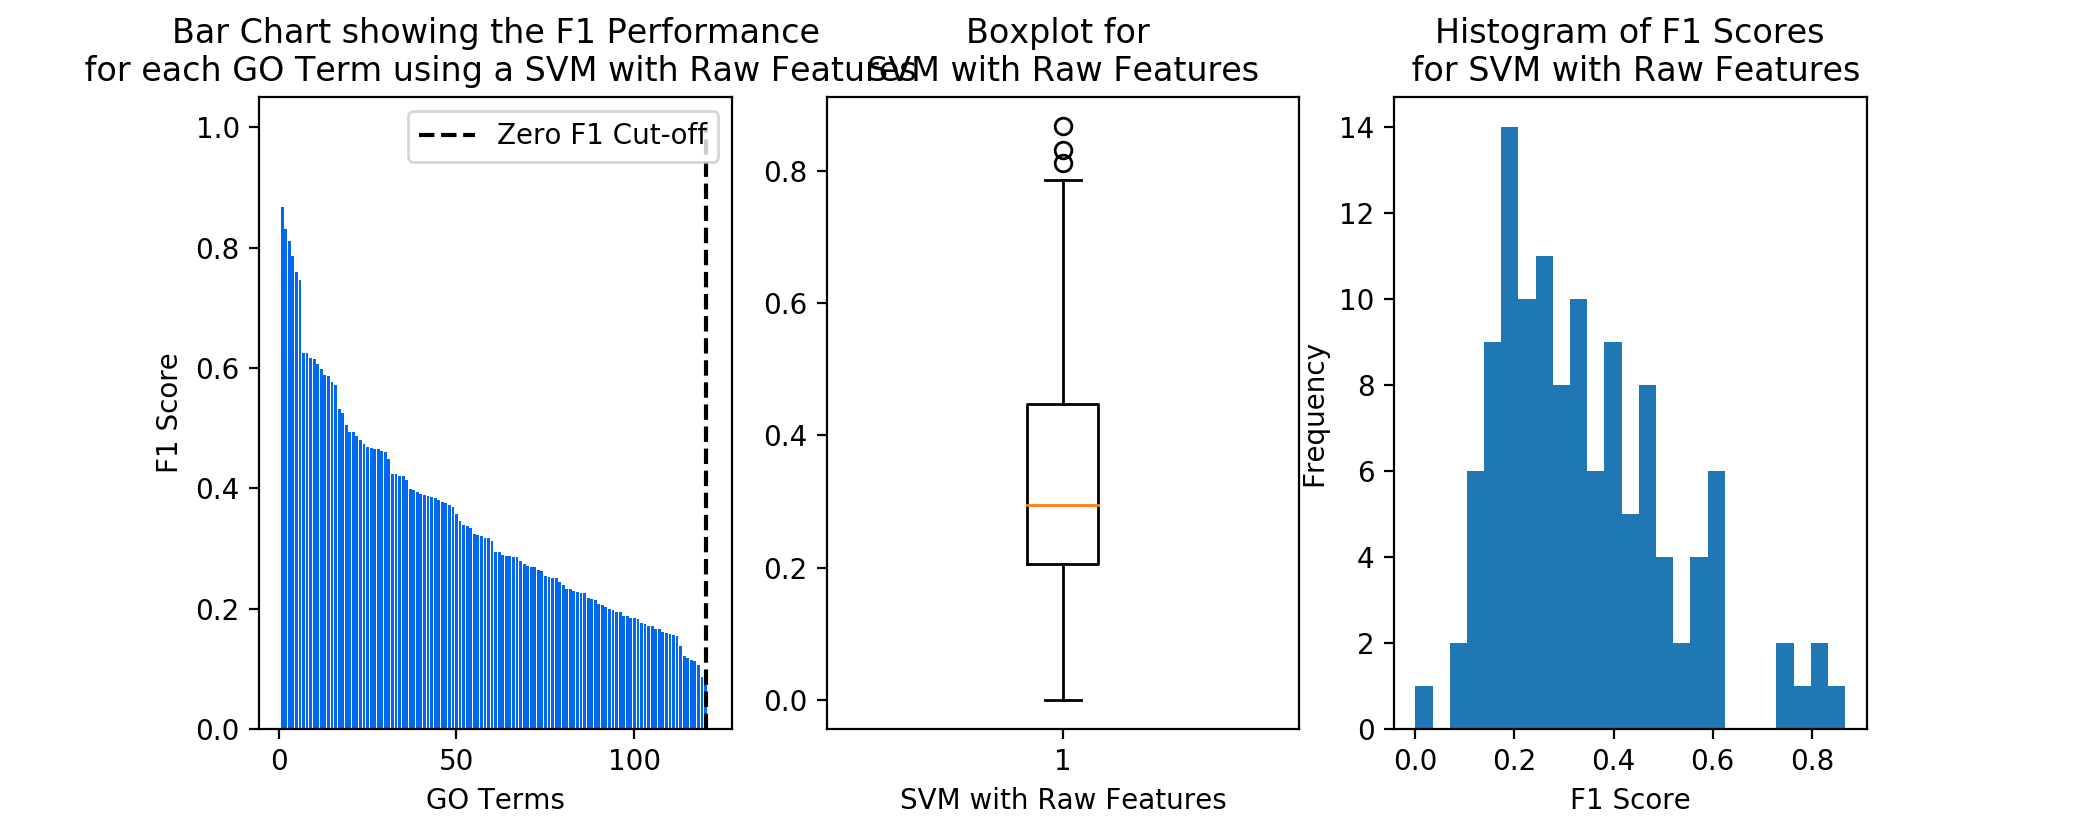

In [43]:
go_names = list([go_term.name for go_term in go_terms])

def go_term_hist(experiment_type, experiment_name, bins, ax):
    f1s = np.array(list(map(lambda x: x.experiments[experiment_type]['f1'], go_terms)))
    
    ax.hist(f1s, bins=bins)
    ax.set_xlabel('F1 Score')
    ax.set_ylabel('Frequency')
    ax.set_title('Histogram of F1 Scores\n for %s' % (experiment_name))

def go_term_bar_chart(experiment_type, experiment_name, ax):
    f1s = np.array(list(map(lambda x: x.experiments[experiment_type]['f1'], go_terms)))

    sorted_indices = np.argsort(f1s)[::-1]

    x = 0
    for index in sorted_indices:
        x += 1
        f1 = f1s[index]
        go_name = go_names[index]
        
        bar = ax.bar(x, f1, color='#0269EF')

    index = np.where(f1s[sorted_indices] == 0)[0][0]
    ax.plot([index, index], [0, 1], 'k--', label='Zero F1 Cut-off')
    ax.set_xlabel('GO Terms')
    ax.set_ylabel('F1 Score')
    ax.set_title('Bar Chart showing the F1 Performance\n for each GO Term using a %s' % (experiment_name))
    ax.legend(loc=1)

    return bar

def go_term_boxplot(experiment_type, experiment_name, ax):
    f1s = np.array(list(map(lambda x: x.experiments[experiment_type]['f1'], go_terms)))
    
    bp = ax.boxplot(f1s)
    ax.set_xlabel(experiment_name)
    ax.set_title('Boxplot for \n%s' % (experiment_name))
    
    return bp

experiment_name = ['LSTM Classifier', 'SVM with LSTM Representations', 'SVM with Raw Features']
for index, experiment_type in enumerate(['standard', 'representation', 'features']):
    fig, ax = plt.subplots(1, 3)
    
    go_term_bar_chart(experiment_type, experiment_name[index], ax[0])

    go_term_boxplot(experiment_type, experiment_name[index], ax[1])
    go_term_hist(experiment_type, experiment_name[index], 25, ax[2])
    plt.show()

In [35]:
from scipy.stats import mannwhitneyu, wilcoxon

print(mannwhitneyu(feature_f1s, representation_f1s))
print(mannwhitneyu(standard_f1s, representation_f1s))

print(wilcoxon(feature_f1s, representation_f1s))
print(wilcoxon(standard_f1s, representation_f1s))

MannwhitneyuResult(statistic=5782.5, pvalue=0.002373672104725152)
MannwhitneyuResult(statistic=4941.0, pvalue=6.0502755181106825e-06)
WilcoxonResult(statistic=1032.0, pvalue=6.13470627084812e-12)
WilcoxonResult(statistic=2642.0, pvalue=0.0066867716495899445)


<IPython.core.display.Javascript object>


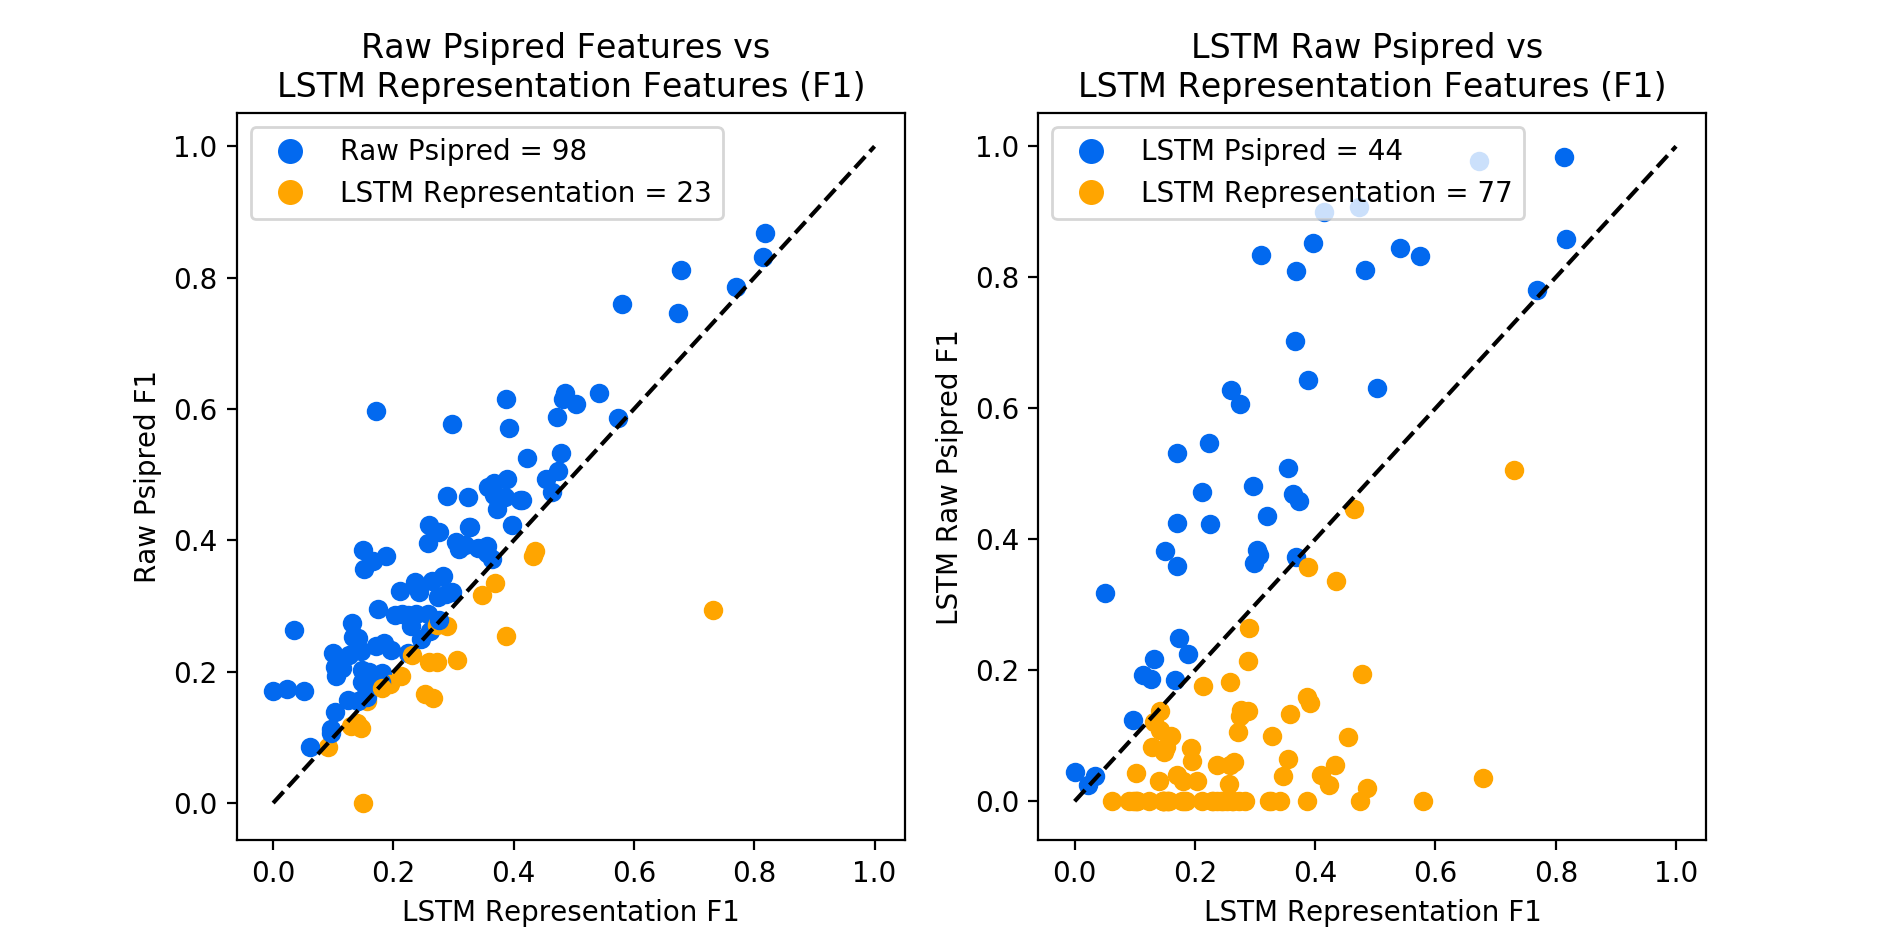

In [36]:
%matplotlib notebook
fig, ax = plt.subplots(1, 2)

number_of_go_terms = len(go_terms)
feature_count = 0
standard_count = 0

for go_term in go_terms:
    feature_f1 = go_term.experiments['features']['f1']
    standard_f1 = go_term.experiments['standard']['f1']
    representation_f1 = go_term.experiments['representation']['f1']
    
    if (feature_f1 > representation_f1):
        color_raw = '#0269EF'
        
        feature_count += 1
    else:
        color_raw = 'orange'
        
    if(standard_f1 > representation_f1):
        color_lstm = '#0269EF'

        standard_count += 1
    else:
        color_lstm = 'orange'

    ax[0].scatter(representation_f1, feature_f1, color=color_raw)
    ax[1].scatter(representation_f1, standard_f1, color=color_lstm)

from matplotlib.lines import Line2D
legend_elements_raw = [Line2D([0], [0], marker='o', color='w', label='Raw Psipred = %d' % feature_count,
                          markerfacecolor='#0269EF', markersize=10), Line2D([0], [0], marker='o', color='w', label='LSTM Representation = %d' % (number_of_go_terms - feature_count),
                          markerfacecolor='orange', markersize=10)]
legend_elements_standard = [Line2D([0], [0], marker='o', color='w', label='LSTM Psipred = %d' % standard_count,
                          markerfacecolor='#0269EF', markersize=10), Line2D([0], [0], marker='o', color='w', label='LSTM Representation = %d' % (number_of_go_terms - standard_count),
                          markerfacecolor='orange', markersize=10)]
# Create the figure
ax[0].legend(handles=legend_elements_raw, loc='upper left')
ax[1].legend(handles=legend_elements_standard, loc='upper left')
    
ax[0].plot([0, 1], [0, 1], 'k--')

ax[0].set_ylabel('Raw Psipred F1')
ax[0].set_xlabel('LSTM Representation F1')
ax[0].set_title("Raw Psipred Features vs \nLSTM Representation Features (F1)")

ax[1].plot([0, 1], [0, 1], 'k--')

ax[1].set_ylabel('LSTM Raw Psipred F1')
ax[1].set_xlabel('LSTM Representation F1')
ax[1].set_title("LSTM Raw Psipred vs \nLSTM Representation Features (F1)")


plt.show()

<IPython.core.display.Javascript object>


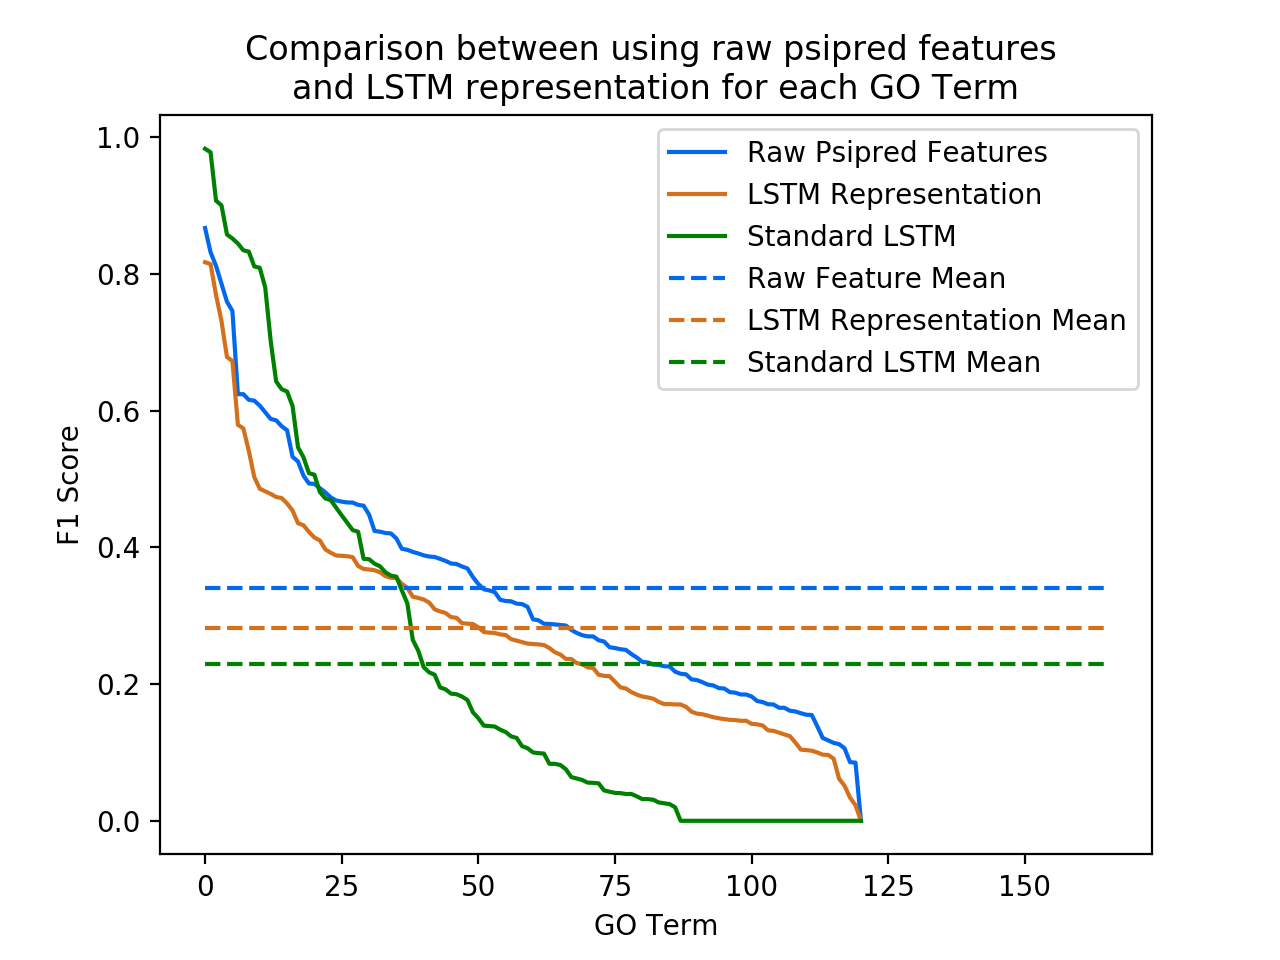

<IPython.core.display.Javascript object>


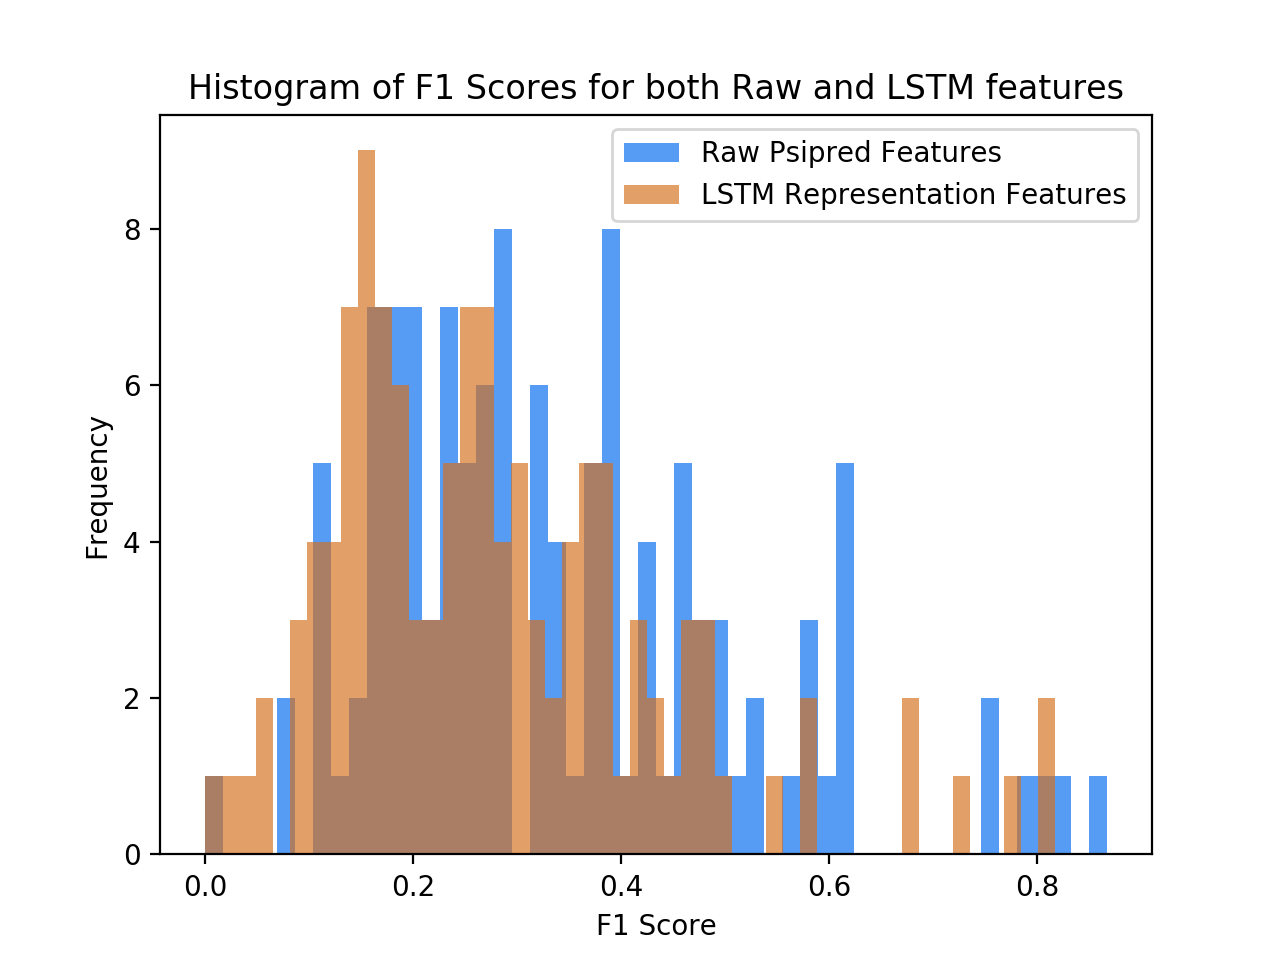

In [37]:
sorted_indices = np.argsort(feature_f1s)[::-1]

sorted_feature_f1s = np.array(feature_f1s)[sorted_indices]
sorted_repr_f1s = sorted(np.array(representation_f1s), reverse=True)
sorted_standard_f1s = sorted(np.array(standard_f1s), reverse=True)

plt.figure()
plt.plot(range(len(sorted_feature_f1s)), sorted_feature_f1s, label="Raw Psipred Features", color='#0269EF')
plt.plot(range(len(sorted_repr_f1s)), sorted_repr_f1s, label="LSTM Representation", color='#D4701C')
plt.plot(range(len(sorted_standard_f1s)), sorted_standard_f1s, label="Standard LSTM", color='g')

plt.plot(range(166), np.repeat(np.mean(feature_f1s), 166), '--', color='#0269EF', label='Raw Feature Mean')
plt.plot(range(166), np.repeat(np.mean(representation_f1s), 166), '--', color="#D4701C", label='LSTM Representation Mean')
plt.plot(range(166), np.repeat(np.mean(standard_f1s), 166), '--', color="green", label='Standard LSTM Mean')

plt.title('Comparison between using raw psipred features \nand LSTM representation for each GO Term')
plt.xlabel('GO Term')
plt.ylabel('F1 Score')
plt.legend()

plt.figure()
plt.hist(feature_f1s, bins=50, color='#0269EFAA', label='Raw Psipred Features')
plt.hist(representation_f1s, bins=50, color='#D4701CAA', label='LSTM Representation Features')
plt.legend()
plt.title("Histogram of F1 Scores for both Raw and LSTM features")
plt.xlabel('F1 Score')
plt.ylabel('Frequency')
plt.show()



In [38]:
def difference(go_term):
    features = go_term.experiments['features']['f1']
    representation = go_term.experiments['representation']['f1']
    
    return representation - features

sorted_go_terms = sorted(go_terms, key=lambda go_term: difference(go_term), reverse=True)

In [39]:
import os
import dill as pickle
from collections import defaultdict
from sklearn.preprocessing import StandardScaler, scale
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean

def tsne_setup(protein_name):
    with open('./cached_material/protein_train_test_splits.pkl', 'rb') as f:
        protein_train_test_splits = pickle.load(f)

    protein_positive_train_set = protein_train_test_splits[protein_name]['train']['positive']
    protein_negative_train_set = protein_train_test_splits[protein_name]['train']['negative']

    feat_positive = []
    feat_negative = []
    repre_positive = []
    repre_negative = []

    for protein in protein_positive_train_set:

        if os.path.exists('./%s/train/%s/representation.pkl' % (protein_name, protein)) and os.path.exists('./data/biological_process/tensors_psipred/%s/features.pkl' % protein):
            with open('./%s/train/%s/representation.pkl' % (protein_name, protein), 'rb') as f:
                representation = pickle.load(f)
                repre_positive.append(representation)

            with open('./data/biological_process/tensors_psipred/%s/features.pkl' % protein, 'rb') as f:
                features = pickle.load(f)
                feat_positive.append(features)

    for protein in protein_negative_train_set:
        if os.path.exists('./%s/train/%s/representation.pkl' % (protein_name, protein)) and os.path.exists('./data/biological_process/tensors_psipred/%s/features.pkl' % protein):
            with open('./%s/train/%s/representation.pkl' % (protein_name, protein), 'rb') as f:
                representation = pickle.load(f)
                repre_negative.append(representation)

            with open('./data/biological_process/tensors_psipred/%s/features.pkl' % protein, 'rb') as f:
                features = pickle.load(f)
                feat_negative.append(features)


    feat_positive = np.array(feat_positive)
    feat_negative = np.array(feat_negative) 

    feat_positive[feat_positive == -111] = 0
    feat_negative[feat_negative == -111] = 0

    feat_positive = np.array([scale(amino, axis=1) for amino in feat_positive])
    feat_negative = np.array([scale(amino, axis=1) for amino in feat_negative])

    repre_positive = scale(repre_positive, axis=1)
    repre_negative = scale(repre_negative, axis=1)

    feat_positive = np.array(feat_positive).reshape(-1, 6000)
    feat_negative = np.array(feat_negative).reshape(-1, 6000)
    repre_positive = np.array(repre_positive)
    repre_negative = np.array(repre_negative)
    
    return feat_positive, feat_negative, repre_positive, repre_negative

def tsne_protein(protein_name, number_components):
    feat_positive, feat_negative, repre_positive, repre_negative = tsne_setup(protein_name)

    tsne_feat_p = TSNE(n_components=3).fit_transform(feat_positive)
    tsne_feat_n = TSNE(n_components=3).fit_transform(feat_negative)

    tsne_repr_p = TSNE(n_components=3).fit_transform(repre_positive)
    tsne_repr_n = TSNE(n_components=3).fit_transform(repre_negative)
    
    return tsne_feat_p, tsne_feat_n, tsne_repr_p, tsne_repr_n

def pca_protein(protein_name, number_components):
    feat_positive, feat_negative, repre_positive, repre_negative = tsne_setup(protein_name)

    tsne_feat = PCA(n_components=number_components).fit_transform(np.concatenate((feat_positive, feat_negative), axis=0))

    tsne_repr = PCA(n_components=number_components).fit_transform(np.concatenate((repre_positive, repre_negative), axis=0))
    
    num_feat_positive = len(feat_positive)
    num_repr_positive = len(repre_positive)
    
    
    return tsne_feat, tsne_repr, num_feat_positive, num_repr_positive, tsne_feat[:num_feat_positive], tsne_feat[num_feat_positive:], tsne_repr[:num_repr_positive], tsne_repr[num_repr_positive:]

def calculate_distance(points):
    return np.mean(points, axis=0)
    

<IPython.core.display.Javascript object>


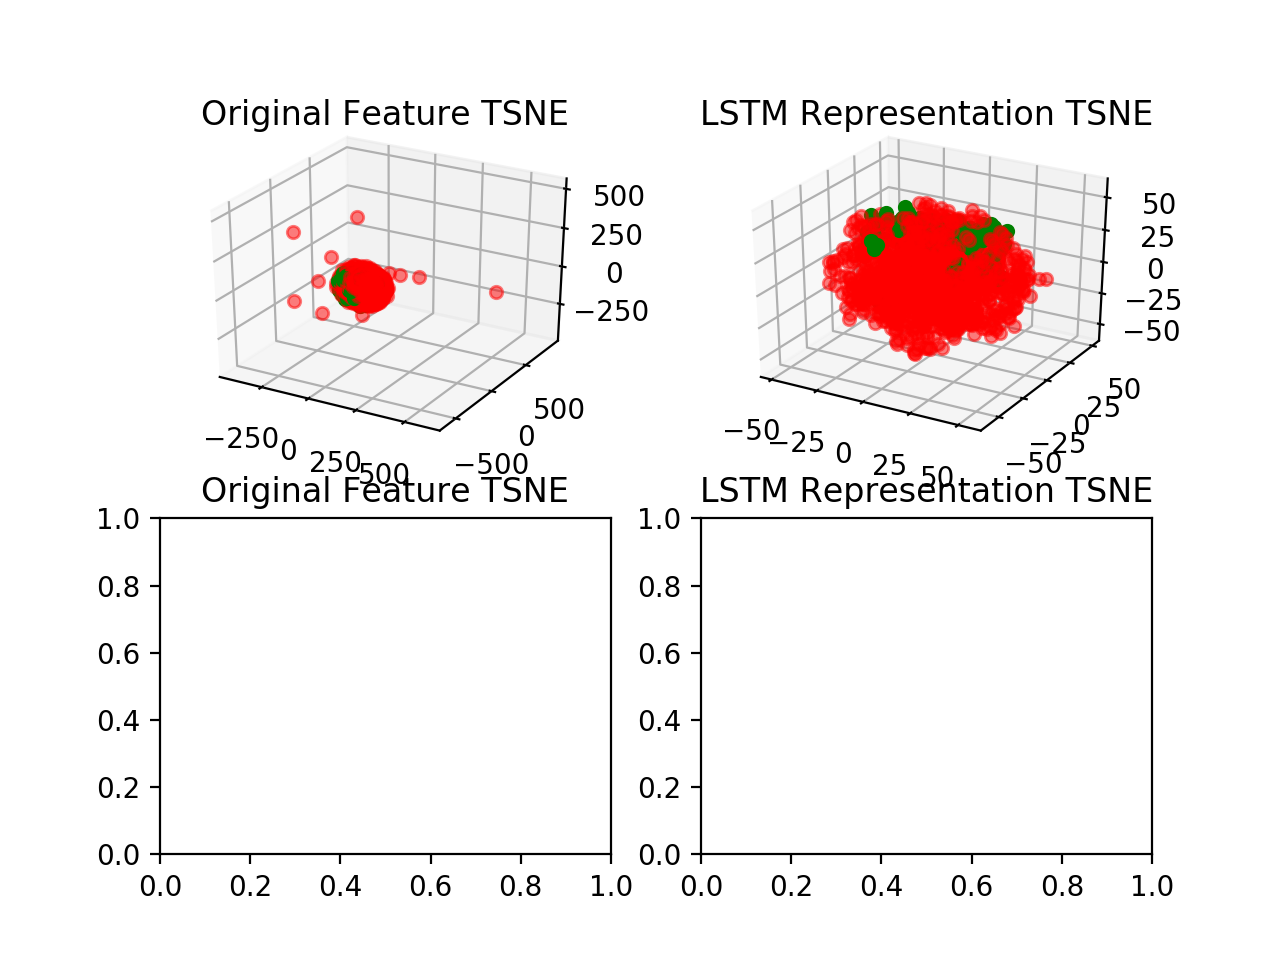

In [217]:
fig = plt.figure()
ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222, projection='3d')

for protein in tsne_feat[:num_feat_positive]:
    ax1.scatter(protein[0], protein[1], protein[2], color='g')

for protein in tsne_feat[num_feat_positive:]:
    ax1.scatter(protein[0], protein[1], protein[2], color='r', alpha=0.5)

for protein in tsne_repr[:num_repr_positive]:
    ax2.scatter(protein[0], protein[1], protein[2], color='g')

for protein in tsne_repr[num_repr_positive:]:
    ax2.scatter(protein[0], protein[1], protein[2], color='r', alpha=0.5)

ax1.set_title('Original Feature TSNE')
ax2.set_title('LSTM Representation TSNE')

ax3.set_title('Original Feature TSNE')
ax4.set_title('LSTM Representation TSNE')

plt.show()


In [20]:
for go_term in sorted_go_terms[:5]:
    feat_positive, feat_negative, _, _ = tsne_setup(go_term.name)
    print('%s, %.2f, %.2f, Positive: %d, Negative: %d' % (go_term.name, go_term.experiments['representation']['f1'], go_term.experiments['features']['f1'], len(feat_positive), len(feat_negative)))

print('\n')
    
for go_term in sorted_go_terms[-5:]:
    feat_positive, feat_negative, _, _ = tsne_setup(go_term.name)
    print('%s, %.2f, %.2f, Positive: %d, Negative: %d' % (go_term.name, go_term.experiments['representation']['f1'], go_term.experiments['features']['f1'], len(feat_positive), len(feat_negative)))


GO0046777, 0.73, 0.29, Positive: 118, Negative: 1781
GO0034976, 0.15, 0.00, Positive: 113, Negative: 2121
GO0048002, 0.39, 0.25, Positive: 121, Negative: 2153
GO0006260, 0.27, 0.16, Positive: 150, Negative: 1988
GO1901653, 0.31, 0.22, Positive: 197, Negative: 2054


GO0006412, 0.39, 0.61, Positive: 338, Negative: 1883
GO0046488, 0.03, 0.26, Positive: 104, Negative: 1993
GO0072657, 0.15, 0.39, Positive: 216, Negative: 2042
GO0045333, 0.30, 0.58, Positive: 121, Negative: 1977
GO0006414, 0.17, 0.60, Positive: 122, Negative: 1891


<IPython.core.display.Javascript object>


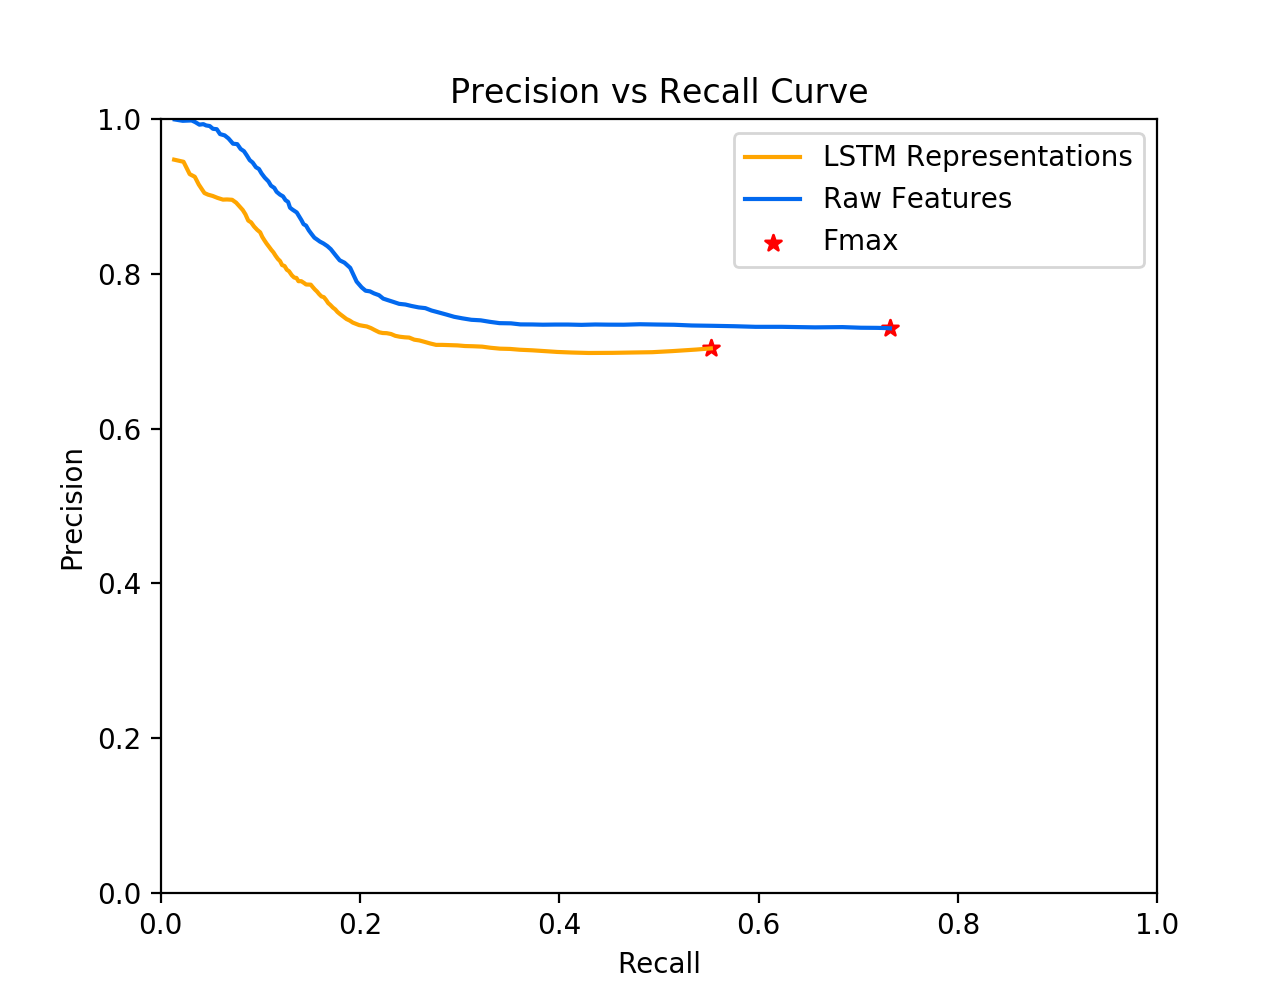

In [65]:
%matplotlib notebook

def precision_recall_curve(file_name, ax, color, label):
    with open(file_name, 'r') as f:
        lines = f.readlines()
        precisions = []
        recalls = []
        for line in lines[5:]:
            results = line.split(',')

            recall = float(results[-3])
            precision = float(results[-2])
            
            precisions.append(precision)
            recalls.append(recall)
            
            #ax.scatter(recall, precision, color='o+')
    
        
        
        ax.plot(precisions, recalls, color=color, label=label)
        ax.scatter([precision], [recall], color='red', marker='*')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title('Precision vs Recall Curve')
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.legend()

fig, ax = plt.subplots(1, 1)
ax.scatter([], [], color='red', marker='*', label='Fmax')
precision_recall_curve('./fmax/LSTM_mixed_probabilities.txt.pr_results', ax, color='orange', label="LSTM Representations")
precision_recall_curve('./fmax/Raw_Mixed_probabilities.txt.pr_results', ax, color='#0269EF', label='Raw Features')

plt.show()
        

In [23]:
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
gamma = [0.0001, 0.001, 0.01, 0.03, 0.1, 0.2, 0.5, 3, 10]

paths = ['./Experiments/Raw/Mixed_weights/LSTM/svm_mixed_hyperparameter_results_3.txt', './Experiments/Raw/Mixed_weights/Features/svm_feature_mixed_hyperparameter_results_3.txt']

def c_analysis(path):
    balanced_cs = []
    imbalanced_cs = []

    with open(path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            results = line.split('{')
            go_term = str(results[0])[:-2]
            if go_term in [gt.name for gt in go_terms]:
                f1 = float(go_term[2])
                param_dict = ast.literal_eval("{" + results[1].split('}')[0] + '}')
                
                if param_dict['class_weight'] == 'balanced':
                    balanced_cs.append(param_dict['C'])
                if param_dict['class_weight'] == None:
                    imbalanced_cs.append(param_dict['C'])

    return balanced_cs, imbalanced_cs
                

In [24]:
model = ['LSTM', "Raw"]
print('\tBalanced\t', 'Imbalanced')
for i, path in enumerate(paths):
    balanced_cs, imbalanced_cs = c_analysis(path)

    print('%s\t%f\t%f' %(model[i], np.mean(balanced_cs), np.mean(imbalanced_cs)))


	Balanced	 Imbalanced
LSTM	175.669231	1148.897674
Raw	230.155300	266.671429
